<a href="https://colab.research.google.com/github/Tikhon239/dul_2021/blob/hw3/Homework/hw3/Homework3_autoregressive_flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --single-branch https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 149 (delta 60), reused 119 (delta 42), pack-reused 0
Receiving objects: 100% (149/149), 27.59 MiB | 28.17 MiB/s, done.
Resolving deltas: 100% (60/60), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=11649 sha256=56325f0d9ba81f0dc970eccb20f82962ee116c28181a6b1edf58eba4e21ecbf0
  Stored in directory: /tmp/pip-ephem-wheel-cache-6fgik_q0/wheels/55/59/29/0fb1c635652157734f

In [29]:
from dul_2021.utils.hw3_utils import *

In [30]:
from typing import Tuple, List, Optional
from tqdm.auto import trange

import numpy as np
import torch
import torch.nn as nn
import torch.optim as opt
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Question 1: Autoregressive Flows for Images

Adapt your PixelCNN implementation from Homework 2 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 2 1(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


In [32]:
class MaskedConv(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.set_mask()
    
    def forward(self, x, labels=None):
        self.weight.data *= self.mask
        return super().forward(x)

    def set_mask(self, color_depended: bool):
        raise NotImplementedError()

In [33]:
class ConvA(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, : h // 2] = 1
        self.mask[:, :, h // 2, : w // 2] = 1
    
class ConvB(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, : h // 2] = 1
        self.mask[:, :, h // 2, : w // 2 + 1] = 1

In [34]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int):
      super().__init__()

      self.model = nn.Sequential(
          ConvB(in_channels=in_channels, out_channels=in_channels // 2, kernel_size=1),
          nn.ReLU(),
          ConvB(in_channels=in_channels // 2, out_channels=in_channels // 2, kernel_size=7, padding=3),
          nn.ReLU(),
          ConvB(in_channels=in_channels // 2, out_channels=in_channels, kernel_size=1)
      )

    def forward(self, x):
        return self.model(x) + x

In [40]:
class FlowPixelCNN(nn.Module):
    def __init__(self,
                 input_shape: Tuple[int, int, int],
                 n_components: int = 5,
                 base_dist = Uniform(0, 1),
                 n_filters: int = 120,
                 n_layers: int = 8):
        super().__init__()
        self.h, self.w, self.c = input_shape
        self.n_components = n_components
        self.base_dist = base_dist

        layers = [ConvA(self.c, n_filters, kernel_size=7, padding=3)]
        for _ in range(n_layers):
            layers.append(ResidualBlock(n_filters))
        layers.extend([
                       nn.ReLU(),
                       ConvB(in_channels=n_filters, out_channels=n_filters, kernel_size=1),
                       nn.ReLU(),
                       ConvB(in_channels=n_filters, out_channels=self.c * 3 * self.n_components, kernel_size=1)
        ])
        
        self.model = nn.Sequential(*layers)

    def forward(self, batch):
        batch_size = batch.shape[0]
        return self.model(batch).reshape(batch_size, self.c, 3 * self.n_components, self.h, self.w)

    def _flow(self, batch):
        log_w, mu, log_s = torch.chunk(self(batch), 3, dim=2)
        w = F.softmax(log_w, dim=0)
        dist = Normal(mu, log_s.exp())   
        batch_r = batch.unsqueeze(1).repeat(1, 1, self.n_components, 1, 1) 
        z = (dist.cdf(batch) * w).sum(dim=2)
        log_det = (dist.log_prob(batch).exp() * w).sum(dim=2).log()
        return z, log_det

    def _log_prob(self, batch):
        z, log_det = self._flow(batch)
        z = torch.clip(z, 0, 1)
        return self.base_dist.log_prob(z) + log_det
        #return (self.base_dist.log_prob(z) + log_det).sum(dim=(2,3))

    def _calculate_loss(self, batch):
        return -self._log_prob(batch).mean()  
  
    def _test(self, test_dataloader: DataLoader) -> float:
        self.eval()
        test_losses = []
        with torch.no_grad():
            for batch in test_dataloader:
                batch = batch.to(device)
                test_losses.append(self._calculate_loss(batch).cpu().numpy())
        return np.mean(test_losses)

    def fit(self,
            train_dataloader: DataLoader,
            test_dataloader: DataLoader,
            epochs: int = 20,
            lr: float = 1e-3) -> Tuple[List[float], List[float]]:

        train_losses = []
        test_losses = []

        optim = torch.optim.Adam(self.parameters(), lr=lr)

        test_losses.append(self._test(test_dataloader))

        for epoch in trange(epochs, desc="Training"):
            self.train()
            epoch_train_losses = []
            for batch in train_dataloader:
                batch = batch.to(device)
                loss = self._calculate_loss(batch)

                optim.zero_grad()
                loss.backward()
                optim.step()

                epoch_train_losses.append(loss.detach().cpu().numpy())

            train_losses.append(np.mean(epoch_train_losses))
            test_losses.append(self._test(test_dataloader))
          
        return train_losses, test_losses

    def sample(self, n: int = 100) -> np.ndarray:
        with torch.no_grad():
            samples = torch.zeros((n, self.c, self.h, self.w), device=device)
            for y in trange(self.h, desc="Sampling"):
                for x in range(self.w):
                    for c in range(self.c):
                        samples[:, c, y, x] = self._log_prob(samples)[:, c, y, x].exp()
        return samples.permute(0, 2, 3, 1).cpu().numpy()    

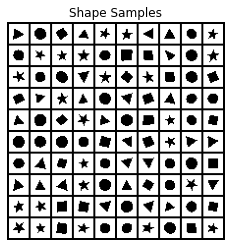

In [41]:
visualize_q1_data()

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [42]:
class PixelDataset(Dataset):
    def __init__(self, data) -> None:
        super().__init__()

        self.data = torch.FloatTensor(data.transpose(0, 3, 1, 2))

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, index):
        return self.data[index]

In [45]:
def q1(train_data, test_data):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  H = W = 20
  Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
      and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
  """
  
  """ YOUR CODE HERE """

  epochs = 1
  batch_size = 128
  lr = 1e-3
  model = FlowPixelCNN(train_data.shape[1:]).to(device)

  train_dataloader = DataLoader(PixelDataset(train_data), batch_size=batch_size, shuffle=True)
  test_dataloader = DataLoader(PixelDataset(test_data), batch_size=batch_size, shuffle=False)

  train_losses, test_losses = model.fit(train_dataloader, test_dataloader, epochs, lr)
  
  return train_losses, test_losses, model.sample(n=100)


### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



In [ ]:
q1_save_results(q1)